# AlexNet

This notebook is an implement of [___ImageNet Classification with Deep Convolutinal Neural Networks___](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) by Krizhevsky et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and can be stored in Google Colab, which we use for the training process. 

The first step of training an AlexNet is to install and import all the dependent libraries for building and training the model. For our AlexNet, we use TensorFlow for training and Matplotlib for visualization of training process

In [1]:
# For pip users
# ! pip install -r ../requirements.txt
# For conda users
! conda install --file ../requirements.txt -y

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities import getCifar
from utilities import show_training_accuracy, show_Cifar_validation_result

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Solving environment: done

# All requested packages already installed.



2022-05-30 14:22:40.572036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0


Here we define function that creates an AlexNet model. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. We define two variables, weight_decay and dropout_rate, as the hyperparameters of the model for kernel regularization and dropout layer, respectively.

In [2]:
def createAlexNet(weight_decay, dropout_rate):
    model = tf.keras.Sequential([
        Input(shape = (32, 32, 3)),
        Resizing(224, 224),
        RandomRotation(.3),
        RandomFlip("horizontal"),
        RandomContrast(.3),
        Conv2D(kernel_size = (11, 11), filters = 96, strides = 4, padding = "same",
            activation = "relu", kernel_regularizer = l2(weight_decay)),
        MaxPooling2D(pool_size = (3, 3), strides = 2, padding = "same"),
        Conv2D(kernel_size = (5, 5), filters = 256, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        MaxPooling2D(pool_size = (3, 3), strides = 2, padding = "same"),
        Conv2D(kernel_size = (3, 3), filters = 384, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        Conv2D(kernel_size = (3, 3), filters = 384, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        Conv2D(kernel_size = (3, 3), filters = 256, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        MaxPooling2D(pool_size = (3, 3), strides = 2, padding = "same"),
        Flatten(),
        Dense(1024, activation = "relu"),
        Dropout(dropout_rate),
        Dense(1024, activation = "relu"),
        Dropout(dropout_rate),
        Dense(10, activation = "softmax")
    ])

    return model

In this part of the program, we get the Cifar 10 dataset using TensorFlow dataset and separate it into training set and test set.

In [3]:
batch_size = 128

train, val, test = getCifar(batch_size)

2022-05-30 14:22:41.990724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0


This part trains AlexNet model we get on Cifar 10 dataset. We store the best weights of each training epochs so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch. We found out that our best hyperparameters are weight decay of 0.5, dropout rate of 0.3, and learning rate of 1e-5. Although this group of hyperparameters are likely to overfit a little bit, it overperforms the group with higher weight decay and dropout rate, so we decided to use this group of hyperparameters.

Epoch 1/150
313/313 [==============================] - 15s 45ms/step - loss: 2.6326 - accuracy: 0.2232 - val_loss: 2.1598 - val_accuracy: 0.3234 - lr: 1.0000e-04
Epoch 2/150
313/313 [==============================] - 14s 45ms/step - loss: 2.1170 - accuracy: 0.3124 - val_loss: 1.9551 - val_accuracy: 0.3714 - lr: 1.0000e-04
Epoch 3/150
313/313 [==============================] - 14s 44ms/step - loss: 1.9295 - accuracy: 0.3613 - val_loss: 1.7793 - val_accuracy: 0.4291 - lr: 1.0000e-04
Epoch 4/150
313/313 [==============================] - 14s 44ms/step - loss: 1.8051 - accuracy: 0.4018 - val_loss: 1.6720 - val_accuracy: 0.4496 - lr: 1.0000e-04
Epoch 5/150
313/313 [==============================] - 14s 46ms/step - loss: 1.7229 - accuracy: 0.4285 - val_loss: 1.6100 - val_accuracy: 0.4666 - lr: 1.0000e-04
Epoch 6/150
313/313 [==============================] - 14s 44ms/step - loss: 1.6593 - accuracy: 0.4502 - val_loss: 1.5395 - val_accuracy: 0.4913 - lr: 1.0000e-04
Epoch 7/150
313/313 [=======

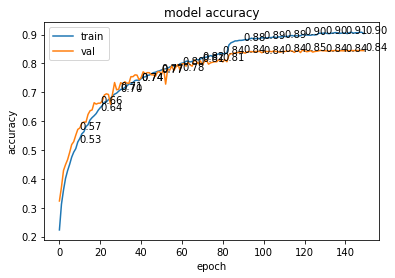

In [8]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "loss", verbose = 0, 
                                        save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10,
                                          verbose = 0, mode = 'auto', min_delta = 0.0001, cooldown = 5, min_lr = 1e-8)

# Hyperparameters
weight_decay = 1e-3
dropout_rate = .5
learning_rate = 1e-4

model = createAlexNet(weight_decay, dropout_rate)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights")

history = model.fit(train, epochs = 150, validation_data = val, callbacks = [lr])

show_training_accuracy(history)

Here we test our model on test set and show how AlexNet predicts on sample images in the test set.

79/79 [==============================] - 1s 15ms/step - loss: 0.6418 - accuracy: 0.8430
Test Accuracy: 84.30%


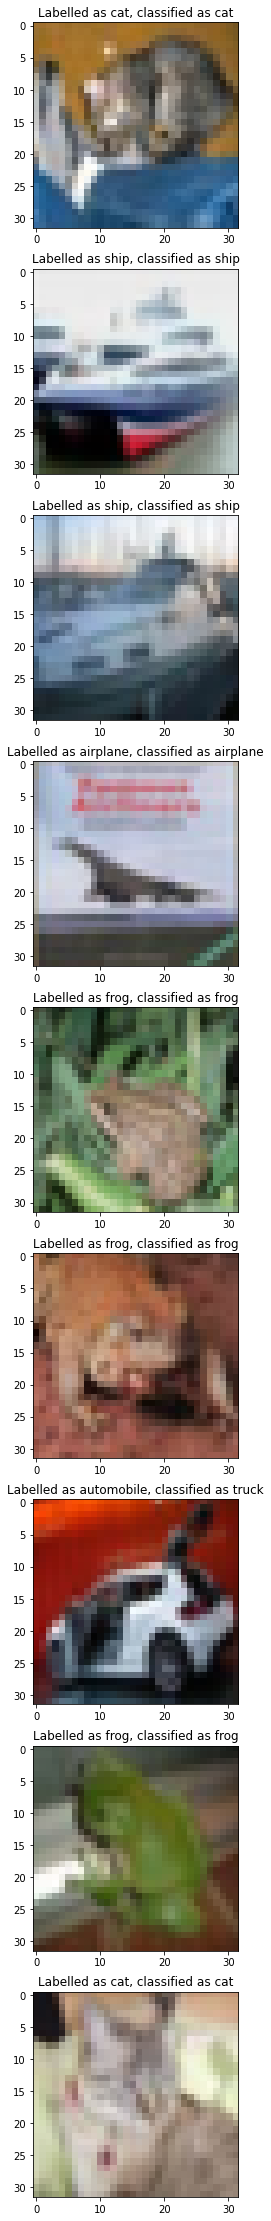

In [9]:
show_Cifar_validation_result(model, test)